+--------------------------------------+
| Train Dataset                        |
|                                      |
| 1. Data Cleaning                     |
| 2. EDA                               |
| 3. Data Preprocessing                |
| 4. Feature Engineering               |
| 5. Handling Class Imbalance (SMOTE)  |
| 6. Model Training                    |
| 7. Cross-Validation & Tuning         |
| 8. Model Evaluation                  |
| 9. Save Best Model                   |
+--------------------------------------+
                  ↓
+--------------------------------------+
| Test Dataset                         |
|                                      |
| 1. Data Cleaning                     |
| 2. Data Preprocessing                |
| 3. Load Best Model                   |
| 4. Make Predictions                  |
| 5. Evaluate Test Performance         |
| 6. Report Results                    |
+--------------------------------------+


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
!unzip /content/new_train_sample.zip
train_dataset= !unzip /content/new_test_sample.zip
pd.DataFrame(train_dataset)

Archive:  /content/new_train_sample.zip
replace new_train_sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: new_train_sample.csv    


,0
0,unzip: cannot find or open /content/new_test_...


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to optimize memory usage
def optimize_memory(df, exclude_cols=[]):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        if col not in exclude_cols:
            df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

# Path to the training dataset
train_dataset_path = r"/content/new_train_sample.csv"

# Processing the dataset in chunks
processed_chunks = []
for chunk in pd.read_csv(train_dataset_path, chunksize=500000, low_memory=False):
    chunk = optimize_memory(chunk, exclude_cols=['IncidentGrade'])  # Exclude target column from optimization
    processed_chunks.append(chunk)

# Combine chunks into a single DataFrame
train_data = pd.concat(processed_chunks, ignore_index=True)

# Cleanup
del processed_chunks

# train dataset overview

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4758418 entries, 0 to 4758417
Data columns (total 46 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int32  
 1   Id                  int64  
 2   OrgId               int16  
 3   IncidentId          int32  
 4   AlertId             int32  
 5   Timestamp           object 
 6   DetectorId          int16  
 7   AlertTitle          int32  
 8   Category            object 
 9   MitreTechniques     object 
 10  IncidentGrade       object 
 11  ActionGrouped       object 
 12  ActionGranular      object 
 13  EntityType          object 
 14  EvidenceRole        object 
 15  DeviceId            int32  
 16  Sha256              int32  
 17  IpAddress           int32  
 18  Url                 int32  
 19  AccountSid          int32  
 20  AccountUpn          int32  
 21  AccountObjectId     int32  
 22  AccountName         int32  
 23  DeviceName          int32  
 24  Networ

<ipython-input-4-bb9c6e2fbe8f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='IncidentGrade', palette='Set2')


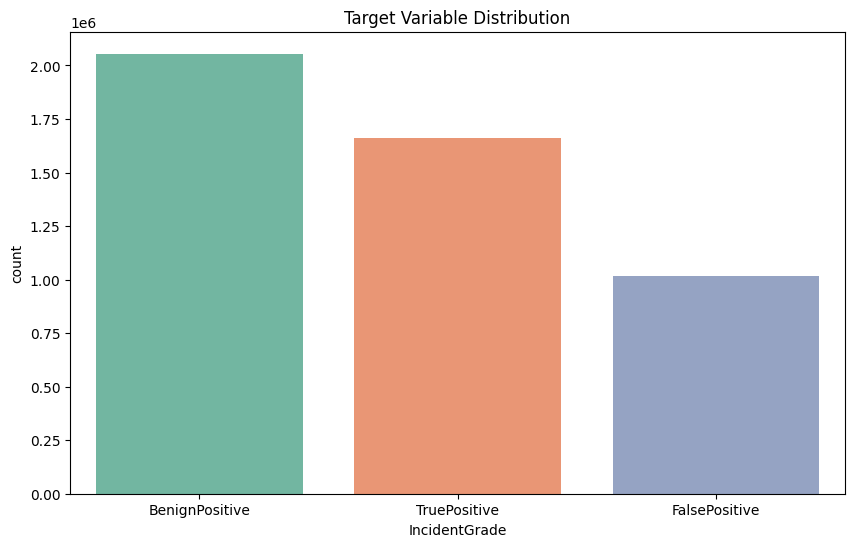

In [4]:
# Dataset overview
print("Dataset Overview:")
print(train_data.info())

# Check for missing values
missing_values = train_data.isnull().sum()
print("\nMissing Values Summary:")
print(missing_values[missing_values > 0])

# Check for duplicate rows
duplicate_count = train_data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")

# Analyze target variable distribution
print("\nTarget Variable Distribution:")
print(train_data['IncidentGrade'].value_counts())

# Plot target variable distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='IncidentGrade', palette='Set2')
plt.title('Target Variable Distribution')
plt.show()





## checking missing values . duplicate, imbalance data



In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

file_path = '/content/new_train_sample.csv'

# Read data in chunks
chunks = pd.read_csv(file_path, chunksize=100000, low_memory=False)
df = pd.concat(chunks, ignore_index=True)

# Handle Missing Values
missing_percentage = df.isnull().sum() / len(df) * 100
columns_to_drop = missing_percentage[missing_percentage > 50].index
print(f"Columns dropped (missing > 50%): {columns_to_drop.tolist()}")
df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Impute missing values
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)

# Outlier Removal
def remove_outliers(data, iqr_multiplier=1.5):
    for col in data.select_dtypes(include=['int64', 'float64']).columns:
        if data[col].nunique() > 10:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

df = remove_outliers(df)

# Feature Engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Hour'] = df['Timestamp'].dt.hour
df.drop(columns=['Timestamp'], inplace=True)

# Scale Numerical Features
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId']
numerical_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=id_columns, errors='ignore')
scaler = MinMaxScaler()
df[numerical_features.columns] = scaler.fit_transform(numerical_features)

# Encode Categorical Features
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType']
for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))

df = pd.get_dummies(df, columns=['State', 'City'])

# Remove Duplicates
df.drop_duplicates(inplace=True)

# Save Preprocessed Data
output_path = '/content/preprocessed_dataset.csv'
df.to_csv(output_path, index=False)
print(f"Data preprocessing complete. Saved to {output_path}.")


Columns dropped (missing > 50%): ['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


<ipython-input-1-31e78c4d361d>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val, inplace=True)


Data preprocessing complete. Saved to /content/preprocessed_dataset.csv.


In [2]:
df

,Unnamed: 0,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,...,ResourceIdName,OSFamily,OSVersion,CountryCode,Year,Month,DayOfWeek,Hour,State_0.0,City_0.0
6,0.168590,60129543933,0,84,104970,0,0.000000,6,2,1,...,0.0,0.0,0.0,0.0,2024,6,2,15,True,True
7,0.927894,1520418425476,8,9452,142992,3,0.033898,9,2,3,...,0.0,0.0,0.0,0.0,2024,6,0,20,True,True
16,0.737274,455266537592,275,568,2817,1,0.008475,6,1,7,...,0.0,0.0,0.0,0.0,2024,6,0,2,True,True
17,0.827341,68719477161,54,168614,222755,6,0.042373,6,2,3,...,0.0,0.0,0.0,0.0,2024,6,0,21,True,True
18,0.569582,901943133951,0,204,185861,0,0.000000,6,2,0,...,0.0,0.0,0.0,0.0,2024,6,1,8,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4758407,0.034319,42949673024,6,2490,1413,17,0.694915,5,0,3,...,0.0,0.0,0.0,0.0,2024,5,4,8,True,True
4758408,0.877237,1211180779162,7,2904,596,22,0.084746,5,1,3,...,0.0,0.0,0.0,0.0,2024,5,6,3,True,True
4758409,0.732842,1365799602593,5,447,406905,0,0.000000,6,2,1,...,0.0,0.0,0.0,0.0,2024,6,0,20,True,True
4758410,0.763551,1443109012225,130,672,547789,0,0.000000,6,0,0,...,0.0,0.0,0.0,0.0,2024,6,4,2,True,True


**Test dataset **

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 46 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailC

<ipython-input-3-5efd74415e0e>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=test_data, x='IncidentGrade', palette='Set2')


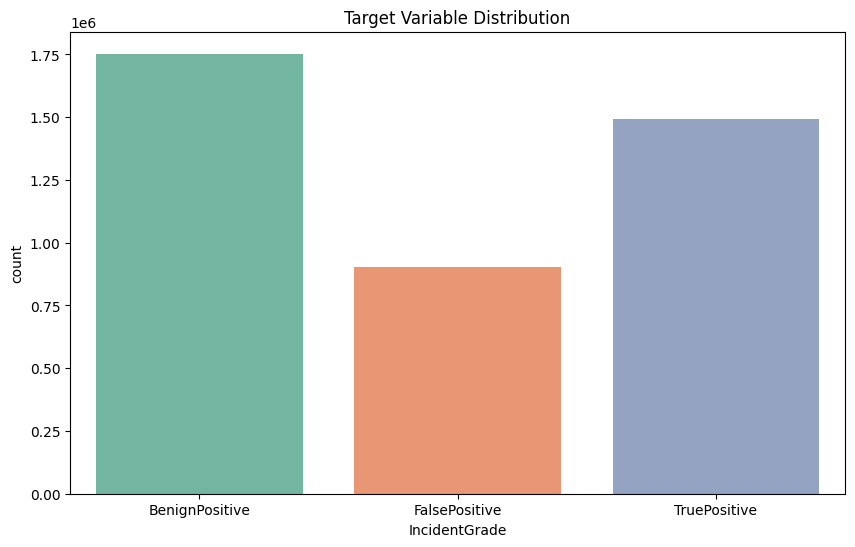

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File path for test dataset
test_dataset_path = '/content/drive/MyDrive/GUIDE_Test.csv'

# Read data in chunks to handle large dataset
processed_test_chunks = []
for chunk in pd.read_csv(test_dataset_path, chunksize=100000, low_memory=False):
    processed_test_chunks.append(chunk)

# Combine all chunks into a single DataFrame
test_data = pd.concat(processed_test_chunks, ignore_index=True)

# Dataset overview
print("Dataset Overview:")
print(test_data.info())

# Check for missing values
missing_values = test_data.isnull().sum()
print("\nMissing Values Summary:")
print(missing_values[missing_values > 0])

# Check for duplicate rows
duplicate_count = test_data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")

# Analyze target variable distribution if the column `IncidentGrade` is present
if 'IncidentGrade' in test_data.columns:
    print("\nTarget Variable Distribution:")
    print(test_data['IncidentGrade'].value_counts())

    # Plot target variable distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=test_data, x='IncidentGrade', palette='Set2')
    plt.title('Target Variable Distribution')
    plt.show()
else:
    print("\nTarget column `IncidentGrade` not found in the test dataset.")





**Data Preprocessing Test dataset**


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# File path for the test dataset
test_dataset_path = '/content/drive/MyDrive/GUIDE_Test.csv'

# Read data in chunks (for large datasets)
chunks = pd.read_csv(test_dataset_path, chunksize=100000, low_memory=False)
test_data = pd.concat(chunks, ignore_index=True)

# Handle Missing Values
missing_percentage = test_data.isnull().sum() / len(test_data) * 100
columns_to_drop = missing_percentage[missing_percentage > 50].index
print(f"Columns dropped (missing > 50%): {columns_to_drop.tolist()}")
test_data.drop(columns=columns_to_drop, axis=1, inplace=True)

# Impute missing values for numeric columns (with median)
numeric_columns = test_data.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_columns:
    if test_data[col].isnull().any():
        median_val = test_data[col].median()
        test_data[col].fillna(median_val, inplace=True)

# Impute missing values for categorical columns (with mode)
categorical_columns = test_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if test_data[col].isnull().any():
        mode_val = test_data[col].mode()[0]
        test_data[col].fillna(mode_val, inplace=True)

# Outlier Removal
def remove_outliers(data, iqr_multiplier=1.5):
    for col in data.select_dtypes(include=['int64', 'float64']).columns:
        if data[col].nunique() > 10:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

test_data = remove_outliers(test_data)

# Feature Engineering (e.g., Timestamp to DateTime-related features)
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], errors='coerce')
test_data['Year'] = test_data['Timestamp'].dt.year
test_data['Month'] = test_data['Timestamp'].dt.month
test_data['DayOfWeek'] = test_data['Timestamp'].dt.dayofweek
test_data['Hour'] = test_data['Timestamp'].dt.hour
test_data.drop(columns=['Timestamp'], inplace=True)

# Scale Numerical Features (except ID columns)
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId']
numerical_features = test_data.select_dtypes(include=['int64', 'float64']).drop(columns=id_columns, errors='ignore')
scaler = MinMaxScaler()
test_data[numerical_features.columns] = scaler.fit_transform(numerical_features)

# Encode Categorical Features (e.g., 'Category', 'IncidentGrade', 'EntityType')
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType']
for col in categorical_columns:
    if col in test_data.columns:
        test_data[col] = label_encoder.fit_transform(test_data[col].astype(str))

# One-hot Encoding for State and City columns (if present)
test_data = pd.get_dummies(test_data, columns=['State', 'City'], drop_first=True)

# Remove Duplicates
test_data.drop_duplicates(inplace=True)

# Save Preprocessed Test Data
output_path = '/content/preprocessed_test_dataset.csv'
test_data.to_csv(output_path, index=False)
print(f"Test dataset preprocessing complete. Saved to {output_path}.")


Columns dropped (missing > 50%): ['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']
Test dataset preprocessing complete. Saved to /content/preprocessed_test_dataset.csv.
